In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split, KFold, GroupKFold, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import Binarizer

In [3]:
def get_clf_eval(y_test , pred):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    roc_auc = roc_auc_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [4]:
# 데이터 로드
df = pd.read_csv("/content/drive/MyDrive/통계최강자전/aug_train.csv")

## 데이터 확인

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382154 entries, 0 to 382153
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    382154 non-null  int64  
 1   Gender                382154 non-null  object 
 2   Age                   382154 non-null  int64  
 3   Driving_License       382154 non-null  int64  
 4   Region_Code           382154 non-null  float64
 5   Previously_Insured    382154 non-null  int64  
 6   Vehicle_Age           382154 non-null  object 
 7   Vehicle_Damage        382154 non-null  object 
 8   Annual_Premium        382154 non-null  float64
 9   Policy_Sales_Channel  382154 non-null  float64
 10  Vintage               382154 non-null  int64  
 11  Response              382154 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 35.0+ MB


In [7]:
df.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,382154.000000,382154.000000,382154.000000,382154.000000,382154.000000,382154.000000,382154.000000,382154.000000,382154.000000
mean,234392.953477,38.545691,0.998108,26.406867,0.489182,30711.271362,111.939812,154.189429,0.163811
std,139527.487326,15.226897,0.043455,13.181241,0.499884,17061.595532,54.286511,83.735107,0.370104
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,115006.250000,25.000000,1.000000,15.000000,0.000000,24546.000000,26.000000,81.000000,0.000000
50%,230461.500000,36.000000,1.000000,28.000000,0.000000,31692.000000,145.000000,154.000000,0.000000
75%,345434.750000,49.000000,1.000000,35.000000,1.000000,39447.750000,152.000000,227.000000,0.000000
max,508145.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


## 시각화

target값 분포 확인

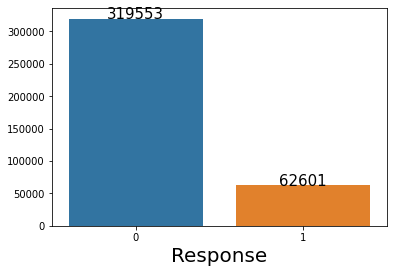

In [8]:
target = sns.countplot(x='Response', data=df)
target.set(ylabel=None)
target.set_xlabel("Response", fontsize = 20)
target.set_ylabel("", fontsize = 20)
for p in target.patches:
    height = p.get_height()
    target.text(p.get_x() + p.get_width() / 2., height + 5, height, ha = 'center', size = 15)

plt.show()

불균형 데이터임을 알 수 있음

저희의 목표는 어떤 고객들이 보험에 더 관심을 갖는지를 알아보는것 입니다.   
그러므로 각 Feature당 Response 여부를 시각화하여, 추가적인 인사이트를 얻어보겠습니다.  
먼저 수치형 데이터부터 살펴보겠습니다. (0: 신청안함 1: 신청함)

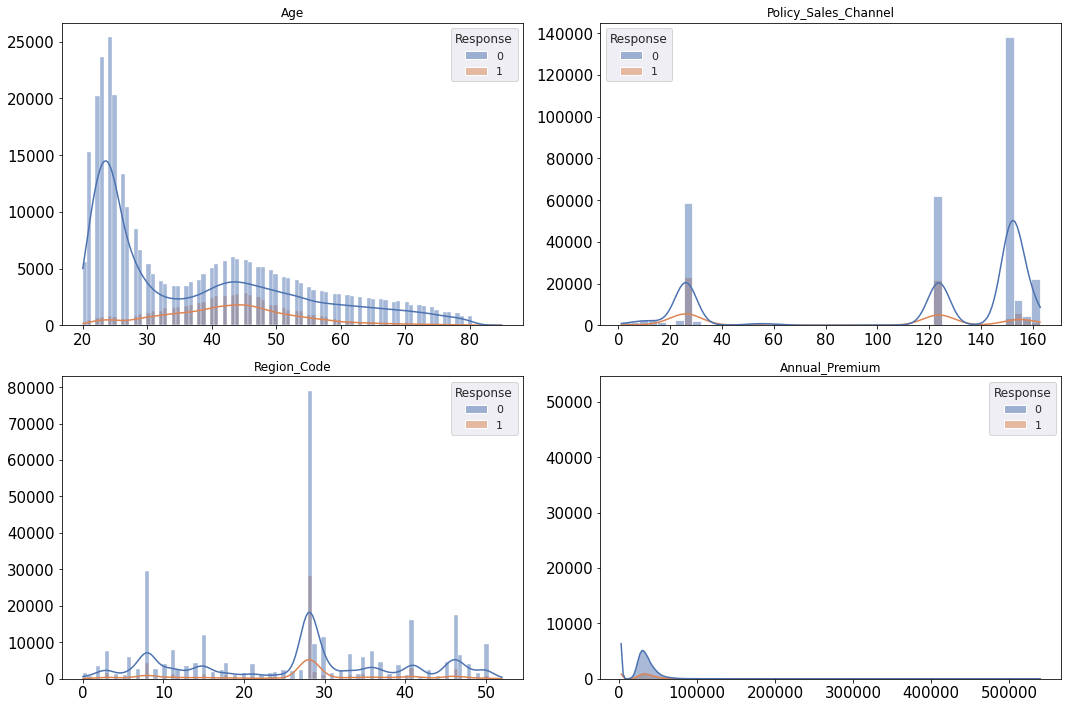

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(15,10))

sns.set(font_scale=1)
sns.histplot(x=df['Age'],kde=True,hue=df['Response'],ax=axes[0][0]).set(title='Age')
sns.histplot(x=df['Policy_Sales_Channel'],kde=True,hue=df['Response'],ax=axes[0][1]).set(title='Policy_Sales_Channel')
sns.histplot(x=df['Region_Code'],kde=True,hue=df['Response'],ax=axes[1][0]).set(title='Region_Code')
sns.histplot(x=df['Annual_Premium'],kde=True,hue=df['Response'],ax=axes[1][1]).set(title='Annual_Premium')

for i in np.arange(0,2):
    for j in np.arange(0,2):
        axes[i][j].set(ylabel=None)
        axes[i][j].set(xlabel=None)
        axes[i][j].tick_params(labelsize=15)

plt.tight_layout()
plt.show()

Age : 20대가 가장 많이 집계되었지만, 신청횟수와 신청률은 저조했다.   
      반면, 30-40대는 20대에 비해 집계 수는 적지만, 신청횟수와 신청률이 압도적으로 높았다.
Policy_Sales_Channel : 특정 채널들에서 압도적인 집계수를 확인할 수 있음.  
but, 150번 채널의 경우 다른 채널에 비해 신청률이 매우 저조함을 알 수 있음.

Region_Code : 특정 지역들에서 압도적인 집계수를 확인할 수 있음 27번 지역에서 높은 신청률을 보임.

Annual_Premium : 이상치가 있음을 확인할 수 있음

다음으로는 범주형 데이터의 Response 여부를 확인해 보겠습니다.

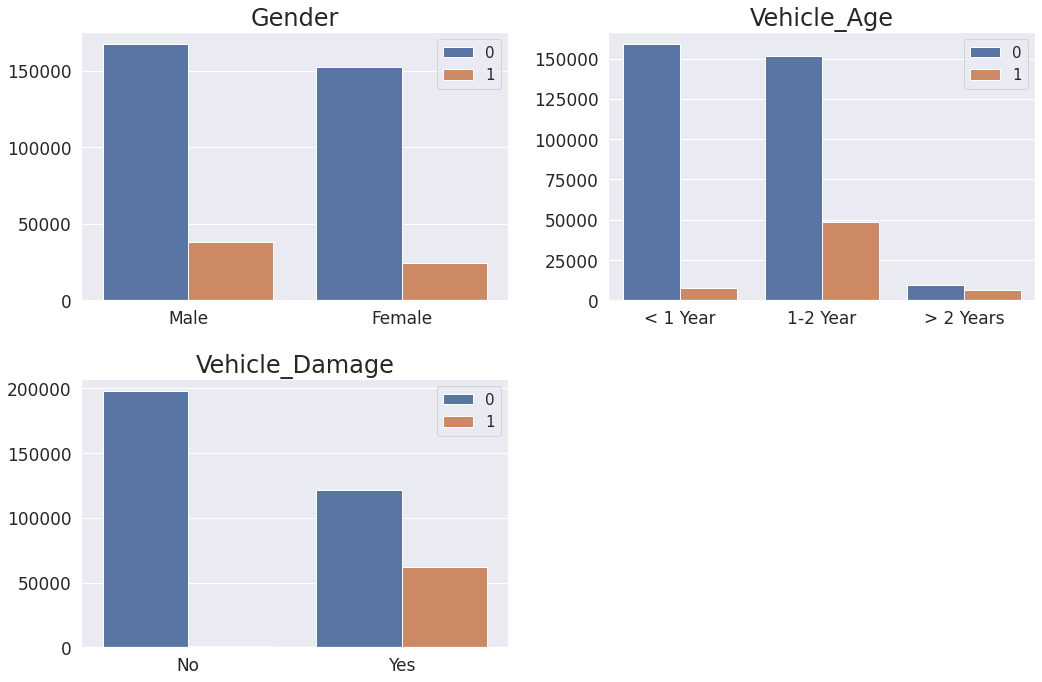

In [10]:
fig, axes = plt.subplots(2,2, figsize=(15,10))

sns.set(font_scale=2)
sns.countplot(x='Gender',hue=df['Response'], data=df, ax=axes[0][0]).set(title='Gender')
sns.countplot(x='Vehicle_Age',hue=df['Response'], data=df, ax=axes[0][1]).set(title='Vehicle_Age')
sns.countplot(x='Vehicle_Damage',hue=df['Response'], data=df, ax=axes[1][0]).set(title='Vehicle_Damage')


for i in np.arange(0,2):
    for j in np.arange(0,2):
        axes[i][j].set(ylabel=None)
        axes[i][j].set(xlabel=None)
        axes[i][j].tick_params(labelsize=17)
        axes[i][j].legend(loc='upper right',fontsize='15')

fig.delaxes(axes[1][1])
plt.tight_layout()
plt.show()

Vehicle_Age : 차량의 나이가 많을수록 신청률이 높아짐을 알 수 있음.

Vehicle_Damage : 차량 손상이 있을 경우 신청률이 압도적으로 높음을 알 수 있음.

### 상관관계

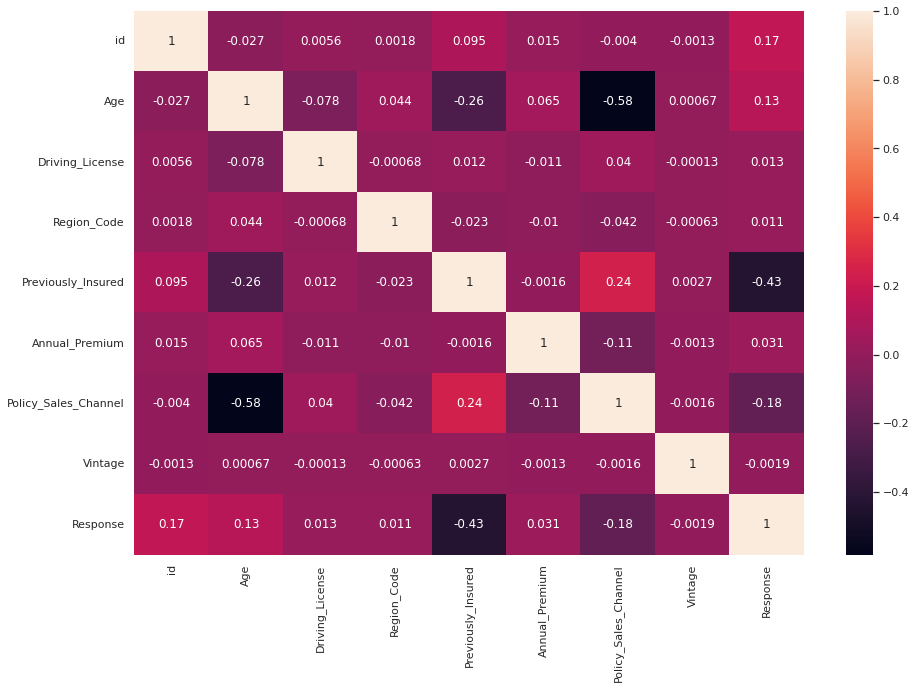

In [11]:
sns.set(font_scale=1)
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(),annot=True)
plt.show()

target과의 관계 : Vehicle_Damage칼럼의 경우 0.45의 유의미한 상관관계를 띄고 있음  
Previously_Insured칼럼 역시 -0.43의 유의미한 상관관계를 띄고 있음  
나머지 칼럼들은 크게 유의미한 상관관계를 찾을 수 없음

독립변수들간의 관계 : Vehicle_Damage와 Previously_Insured는 -0.85의 높은 상관관계를 보임
다중공선성을 의심할 수 있음

## 결측치 확인

In [12]:
def check_missing_col(dataframe):
    missing_col = []
    counted_missing_col = 0
    for i,col in enumerate(dataframe.columns):
        missing_values = sum(dataframe[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            counted_missing_col +=1
            print('결측치가 있는 칼럼은: %s입니다.'%col)
            print('해당 칼럼에 총 %s개의 결측치가 존재합니다. '%missing_values)
            missing_col.append([col, dataframe[col].dtype])
    if counted_missing_col == 0:
        print('결측치가 존재하지 않습니다.')
    return missing_col

missing_col = check_missing_col(df)

결측치가 존재하지 않습니다.


## 불필요한 변수 삭제

In [13]:
df.drop(['id'], axis=1, inplace=True)

## 이상치 처리

boxplot 확인

[Text(0.5, 1.0, 'Annual_Premium')]

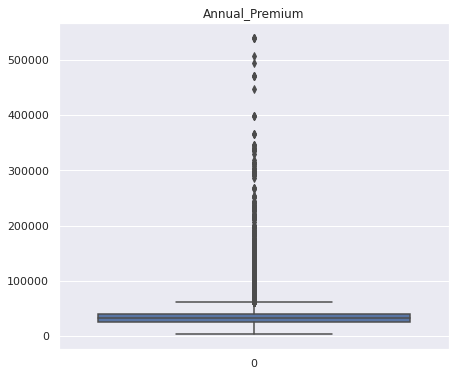

In [14]:
plt.figure(figsize=(7,6))
sns.boxplot(data=df['Annual_Premium']).set(title = 'Annual_Premium')

[Text(0.5, 1.0, 'Age')]

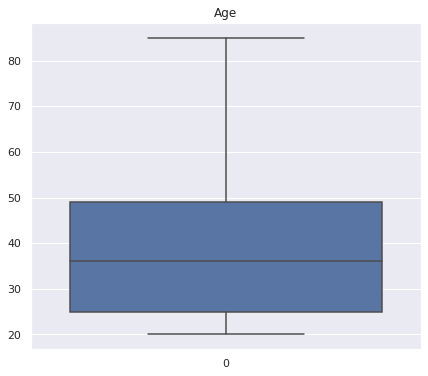

In [15]:
plt.figure(figsize=(7,6))
sns.boxplot(data=df['Age']).set(title = 'Age')

[Text(0.5, 1.0, 'Vintage')]

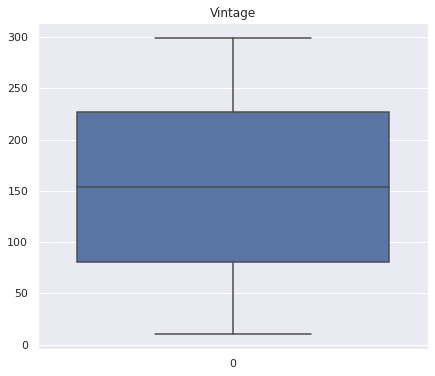

In [16]:
plt.figure(figsize=(7,6))
sns.boxplot(data=df['Vintage']).set(title = 'Vintage')

Annual_Premium 분포 확인

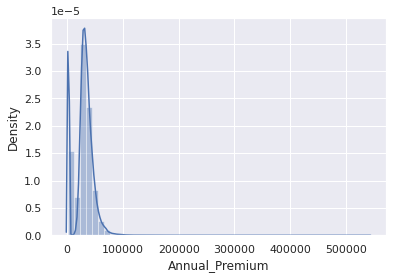

In [17]:
sns.distplot(df['Annual_Premium'])

In [18]:
# 이상치들 상한값, 하한값으로 대체
def outlier(df):
    IQR = df.quantile(0.75) - df.quantile(0.25)
    line_down = df.quantile(0.25) - IQR*1.5
    line_up = df.quantile(0.75) + IQR*1.5

    df = df.clip(line_down, line_up)

    return df

df['Annual_Premium'] = outlier(df['Annual_Premium'])

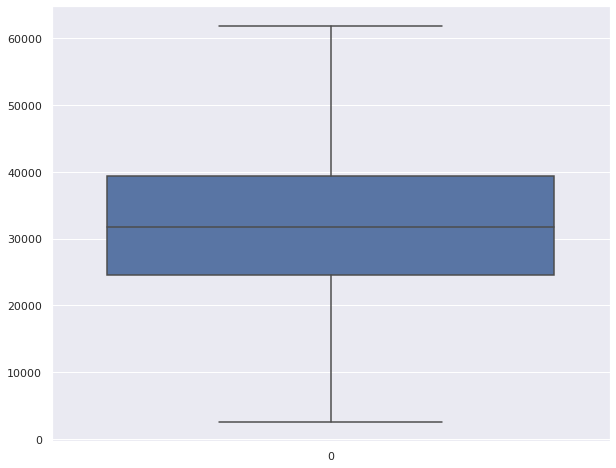

In [19]:
# 이상치 처리 후 boxplot 확인
plt.figure(figsize=(10,8))
sns.boxplot(data=df['Annual_Premium'])

## Age를 범주화하여 Age_level 생성

모든 기준은 대한민국 평균 연령로 결정  
1) 평균 취업 연령 : 28세  
2) 평균 결혼 및 출산 연령 : 32세  
3) 평균 내 집 마련 연령 : 40세  
4) 평균 은퇴 연령 : 60세   
를 이용해 Age를 범주화하여 Age_level 생성

In [20]:
condition1 = (df['Age'] < 28)
condition2 = (df['Age'] >= 28) & (df['Age'] < 32)
condition3 = (df['Age'] >= 32) & (df['Age'] < 40)
condition4 = (df['Age'] >= 40) & (df['Age'] < 60)
condition5 = (df['Age'] >= 60)

In [21]:
df['Age_level'] = np.where(condition1, 0, np.where(condition2,1,np.where(condition3,2,np.where(condition4,3,np.where(condition5,4,"NaN")))))

In [22]:
df['Age_level'] = pd.to_numeric(df['Age_level'])

In [23]:
df.drop(['Age'],axis= 1, inplace=True)

## Encoding

In [24]:
from sklearn.preprocessing import LabelEncoder

In [25]:
# 범주형 변수들 LabelEnoding
features = ['Gender', 'Vehicle_Damage', 'Vehicle_Age']

In [26]:
for o_col in features:
    encoder = LabelEncoder()
    encoder.fit(df[o_col])
    df[o_col] = encoder.transform(df[o_col])

## Scaling

In [27]:
df['Annual_Premium'] = np.log1p(df['Annual_Premium'])

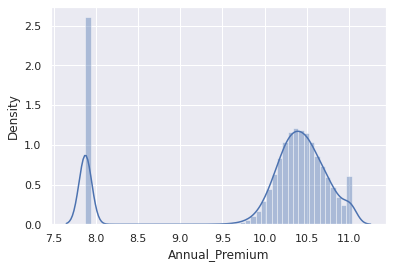

In [28]:
sns.distplot(df['Annual_Premium'])

## train_test_split

In [37]:
X = df.drop(['Response','Vintage'],axis= 1)
y = df['Response']

X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.2, random_state=42)

## OverSampling

In [259]:
from imblearn.over_sampling import ADASYN

In [260]:
adasyn = ADASYN(random_state= 42)
X_train_over, y_train_over = adasyn.fit_resample(X_train, y_train)

## Logistic Regression

In [261]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lgr = LogisticRegression(random_state=42)
lgr.fit(X_train_over, y_train_over)
lgr_pred = lgr.predict(X_test)
get_clf_eval(y_test ,lgr_pred)

In [264]:
pred_proba = lgr.predict_proba(X_test)

# Binarizer의 threshold 값을 0.65로 설정
custom_threshold = 0.65

# predict_proba() 결과 값의 두 번째 컬럼, 즉 Positive 클래스의 컬럼 하나만 추출하여 Binarizer를 적용
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

# Vintage 제거 전
# 정확도: 0.7309, 정밀도: 0.3625, 재현율: 0.8264,    F1: 0.5040, AUC:0.7692

# Vintage 제거 후
# 정확도: 0.7642, 정밀도: 0.4041, 재현율: 0.8960,    F1: 0.5570, AUC:0.8170

오차 행렬
[[47083 16706]
 [ 1315 11327]]
정확도: 0.7642, 정밀도: 0.4041, 재현율: 0.8960,    F1: 0.5570, AUC:0.8170


## RandomForest

In [29]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

오차 행렬
[[58562  5227]
 [ 7627  5015]]
정확도: 0.8318, 정밀도: 0.4897, 재현율: 0.3967,    F1: 0.4383, AUC:0.6574


In [31]:
pred_proba = rf.predict_proba(X_test)

# Binarizer의 threshold 값을 0.1로 설정
custom_threshold = 0.1
# predict_proba() 결과 값의 두 번째 컬럼, 즉 Positive 클래스의 컬럼 하나만 추출하여 Binarizer를 적용
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

# 정확도: 0.7719, 정밀도: 0.4055, 재현율: 0.8142,    F1: 0.5414, AUC:0.7888

오차 행렬
[[46528 17261]
 [ 1134 11508]]
정확도: 0.7593, 정밀도: 0.4000, 재현율: 0.9103,    F1: 0.5558, AUC:0.8199


## LightGBM

In [32]:
from lightgbm import LGBMClassifier

In [33]:
lgbm = LGBMClassifier(n_estimators =3042, min_child_weight = 2, max_depth = 14, learning_rate = 0.06, random_state= 42, class_weight = 'balanced')

lgbm.fit(X_train, y_train)


오차 행렬
[[49376 14413]
 [ 1486 11156]]
정확도: 0.7920, 정밀도: 0.4363, 재현율: 0.8825,    F1: 0.5839, AUC:0.8283


LGBM threshold 변경

In [35]:
pred_proba = lgbm.predict_proba(X_test)

# Binarizer의 threshold 값을 0.67로 설정
custom_threshold = 0.67

# predict_proba() 결과 값의 두 번째 컬럼, 즉 Positive 클래스의 컬럼 하나만 추출하여 Binarizer를 적용
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

# 정확도: 0.8214, 정밀도: 0.4764, 재현율: 0.8039,    F1: 0.5983, AUC:0.8144

오차 행렬
[[52967 10822]
 [ 2756  9886]]
정확도: 0.8223, 정밀도: 0.4774, 재현율: 0.7820,    F1: 0.5929, AUC:0.8062


LGBM 파라미터 튜닝

In [53]:
def LGBM_cv(max_depth,learning_rate, n_estimators
             ,min_child_weight, silent=True):

      # 모델 정의
    model = LGBMClassifier(max_depth=int(max_depth),
                                learning_rate=learning_rate,
                                n_estimators=int(n_estimators),
                                min_child_weight=int(min_child_weight)
                                # class_weights = class_weights
                                )
      # 모델 훈련
    model.fit(X_train, y_train)

      # 예측값 출력
    y_pred= model.predict(X_test)

      # metric 계산
    f1 = f1_score(y_test,y_pred)
      # 오차 최적화로 사용할 metric 반환
    return f1

In [ ]:
# !pip install bayesian-optimization

In [55]:
from bayes_opt import BayesianOptimization
import numpy as np

  # 실험해보고자하는 hyperparameter 집합
pbounds = {'max_depth': (3, 15),
                'learning_rate': (0.01, 0.2),
                'n_estimators': (100, 5000),
                'min_child_weight': (0, 10)
                            }


  # Bayesian optimization 객체 생성
  # f : 탐색 대상 함수, pbounds : hyperparameter 집합
  # verbose = 2 항상 출력, verbose = 1 최댓값일 때 출력, verbose = 0 출력 안함
  # random_state : Bayesian Optimization 상의 랜덤성이 존재하는 부분을 통제 
bo=BayesianOptimization(f=LGBM_cv, pbounds=pbounds, verbose=1, random_state=42)    

  # 메소드를 이용해 최대화 과정 수행
  # init_points :  초기 Random Search 갯수
  # n_iter : 반복 횟수 (몇개의 입력값-함숫값 점들을 확인할지! 많을 수록 정확한 값을 얻을 수 있다.)
  # acq : Acquisition Function들 중 Expected Improvement(EI) 를 사용
  # xi : exploration 강도 (기본값은 0.0)
bo.maximize(init_points=2, n_iter=10, acq='ei', xi=0.01)

  # ‘iter’는 반복 회차, ‘target’은 목적 함수의 값, 나머지는 입력값을 나타냅니다. 
  # 현재 회차 이전까지 조사된 함숫값들과 비교하여, 현재 회차에 최댓값이 얻어진 경우, 
  # bayesian-optimization 라이브러리는 이를 자동으로 다른 색 글자로 표시하는 것을 확인할 수 있습니다

  # 찾은 파라미터 값 확인
print(bo.max) 


|   iter    |  target   | learni... | max_depth | min_ch... | n_esti... |
-------------------------------------------------------------------------
|  5        |  0.4469   |  0.1107   |  13.14    |  5.909    |  3.033e+0 |
|  8        |  0.4494   |  0.08514  |  12.41    |  3.95     |  3.035e+0 |
|  9        |  0.4536   |  0.06685  |  14.35    |  1.969    |  3.042e+0 |
{'target': 0.4535610361112436, 'params': {'learning_rate': 0.06685291920897127, 'max_depth': 14.34543799916238, 'min_child_weight': 1.9689379371737359, 'n_estimators': 3042.0778944116805}}


## CatBoost

In [ ]:
# !pip install catboost

In [38]:
from sklearn.utils.class_weight import compute_class_weight

# 불균형한 클래스인 것으로 확인되어 class_weight = 'balanced'로 설정해준다. 
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

In [39]:
from catboost import CatBoostClassifier

In [40]:
cb = CatBoostClassifier(random_state=42, class_weights= class_weights, verbose = 0)

In [41]:
#모델 학습
cb.fit(X_train, y_train)

cb_pred = cb.predict(X_test)

threshold 변경

In [42]:
pred_proba = cb.predict_proba(X_test)

# Binarizer의 threshold 값을 0.7로 설정
custom_threshold = 0.7

# predict_proba() 결과 값의 두 번째 컬럼, 즉 Positive 클래스의 컬럼 하나만 추출하여 Binarizer를 적용
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

# Vintage 제거 전
# 정확도: 0.8237, 정밀도: 0.4805, 재현율: 0.8090,    F1: 0.6029, AUC:0.8179
# Vintage 제거 후
# 정확도: 0.8239, 정밀도: 0.4809, 재현율: 0.8117,    F1: 0.6039, AUC:0.8190

오차 행렬
[[51936 11853]
 [ 2528 10114]]
정확도: 0.8118, 정밀도: 0.4604, 재현율: 0.8000,    F1: 0.5845, AUC:0.8071


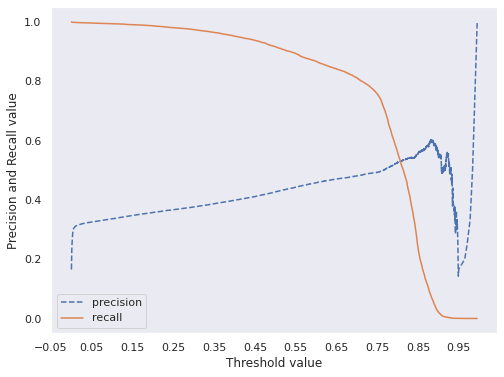

In [278]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # x축을 threshold 값, y축을 정밀도, 재현율로 그리기
    plt.figure(figsize=(8,6))
    thresholds_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0: thresholds_boundary], linestyle= '--', label='precision')
    plt.plot(thresholds, recalls[0: thresholds_boundary], label='recall')
    
    # threshold의 값 X축의 scale을 0.1 단위로 변경
    stard, end = plt.xlim()
    plt.xticks(np.round(np.arange(stard, end, 0.1), 2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()
    plt.show()

precision_recall_curve_plot(y_test, cb.predict_proba(X_test)[:,1])

## SHAP Value

In [ ]:
# !pip install shap

In [79]:
import shap
import skimage

In [80]:
explainer = shap.TreeExplainer(cb) # Tree model Shap Value 확인 객체 지정
shap_values = explainer.shap_values(X_train) # Shap Values 계산

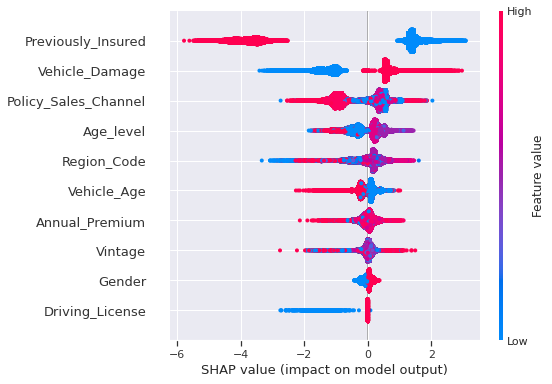

In [43]:
shap.initjs()
shap.summary_plot(shap_values, X_train)

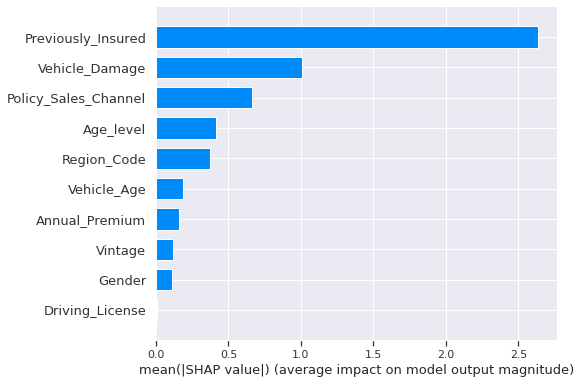

In [81]:
shap.initjs()
shap.summary_plot(shap_values, X_train, plot_type='bar')